# GARCH Parameter Analysis

This notebook analyzes the estimated GARCH(1,1) parameters (`omega`, `alpha`, `beta`, `nu`) produced by the rolling window estimation.
We verify parameter stability, stationarity conditions (`alpha + beta < 1`), and inspect distributions for potential issues.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [11]:
# Define paths
DATA_DIR = Path("../data/output")
PARAMS_FILE = DATA_DIR / "garch_parameters.csv"

if not PARAMS_FILE.exists():
    print(f"❌ File not found: {PARAMS_FILE}")
    print("Please run the GARCH estimation script first.")
else:
    print(f"✅ Found parameter file: {PARAMS_FILE}")

✅ Found parameter file: ..\data\output\garch_parameters.csv


In [12]:
# Load Data
try:
    df = pd.read_csv(PARAMS_FILE)
    df['date'] = pd.to_datetime(df['date'])
    print(f"Loaded {len(df):,} parameter sets across {df['gvkey'].nunique()} firms.")
    display(df.head())
except Exception as e:
    print(f"Error loading data: {e}")

Loaded 5,100 parameter sets across 34 firms.


,gvkey,date,omega,alpha,beta,nu,mu,persistence,unconditional_variance,log_likelihood,aic,bic,num_observations
0,14447,2012-07-31,0.000005,0.033749,0.939910,11.257064,0.000868,0.973659,0.000189,-858.380631,1726.761263,1747.874144,504
1,14447,2012-08-31,0.000006,0.037055,0.933034,10.676033,0.000708,0.970090,0.000185,-856.540992,1723.081984,1744.194865,504
2,14447,2012-09-28,0.000005,0.035662,0.935101,12.345621,0.000333,0.970763,0.000185,-857.083168,1724.166336,1745.279217,504
3,14447,2012-10-31,0.000006,0.035331,0.934905,12.391436,0.000344,0.970235,0.000185,-859.287571,1728.575142,1749.688024,504
4,14447,2012-11-30,0.000005,0.037168,0.933630,11.473199,0.000412,0.970798,0.000183,-857.160110,1724.320220,1745.433101,504


## 1. Parameter Summary Statistics
Check the descriptive statistics for each parameter.

In [13]:
param_cols = ['omega', 'alpha', 'beta', 'nu', 'persistence']
df[param_cols].describe()

,omega,alpha,beta,nu,persistence
count,5.100000e+03,5100.000000,5100.000000,5100.000000,5100.000000
mean,2.785150e-05,0.142813,0.668990,4.241077,0.811802
std,1.366743e-04,0.222605,0.343990,2.012283,0.283672
min,7.594511e-15,0.000000,0.000000,2.050000,0.000000
25%,9.128773e-07,0.005363,0.445243,2.963416,0.757807
50%,3.861470e-06,0.065513,0.813695,3.932343,0.961708
75%,1.576715e-05,0.147668,0.959359,4.944379,0.993579
max,2.611463e-03,1.000000,1.000000,27.486718,1.000035


## 2. Persistence Analysis (`alpha + beta`)
For a stable GARCH process, $\alpha + \beta < 1$. If fit is close to 1, volatility shocks persist for a long time. If $\ge 1$, the process is non-stationary (IGARCH).

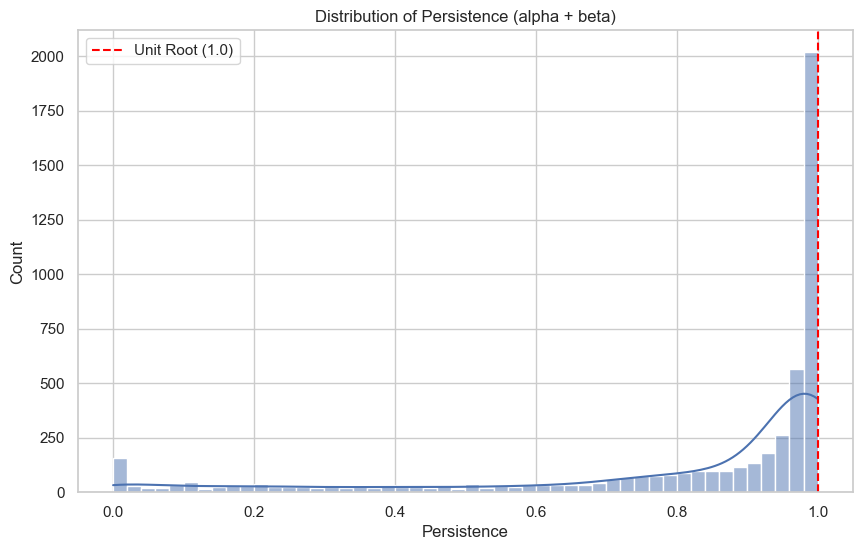

Number of estimations with persistence >= 0.999: 819 (16.06%)


In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['persistence'], bins=50, kde=True)
plt.axvline(1.0, color='red', linestyle='--', label='Unit Root (1.0)')
plt.title('Distribution of Persistence (alpha + beta)')
plt.xlabel('Persistence')
plt.legend()
plt.show()

problematic_persistence = df[df['persistence'] >= 0.999]
print(f"Number of estimations with persistence >= 0.999: {len(problematic_persistence)} ({len(problematic_persistence)/len(df):.2%})")

## 3. Parameter Distributions

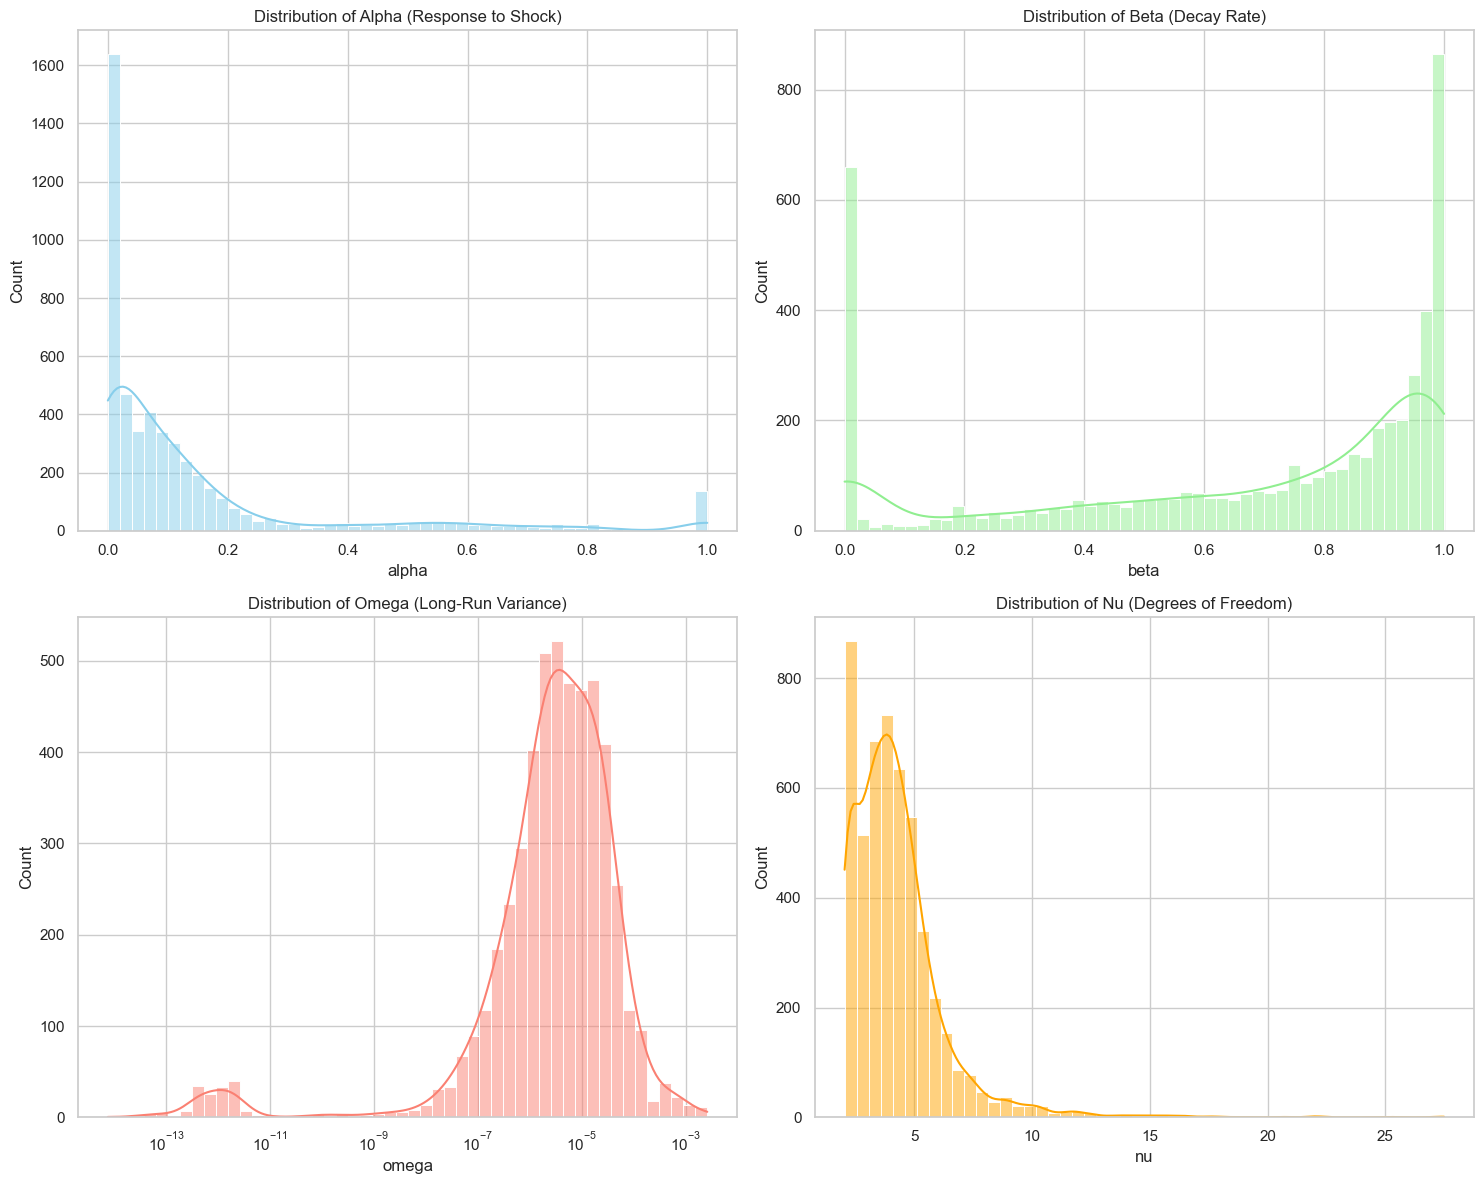

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.histplot(df['alpha'], bins=50, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Alpha (Response to Shock)')

sns.histplot(df['beta'], bins=50, kde=True, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Distribution of Beta (Decay Rate)')

sns.histplot(df['omega'], bins=50, kde=True, ax=axes[1, 0], color='salmon', log_scale=True)
axes[1, 0].set_title('Distribution of Omega (Long-Run Variance)')

sns.histplot(df['nu'], bins=50, kde=True, ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Distribution of Nu (Degrees of Freedom)')

plt.tight_layout()
plt.show()

## 4. Scatter Plot: Alpha vs Beta
Visualizing the feasible region. Most points should be below the line $x + y = 1$.

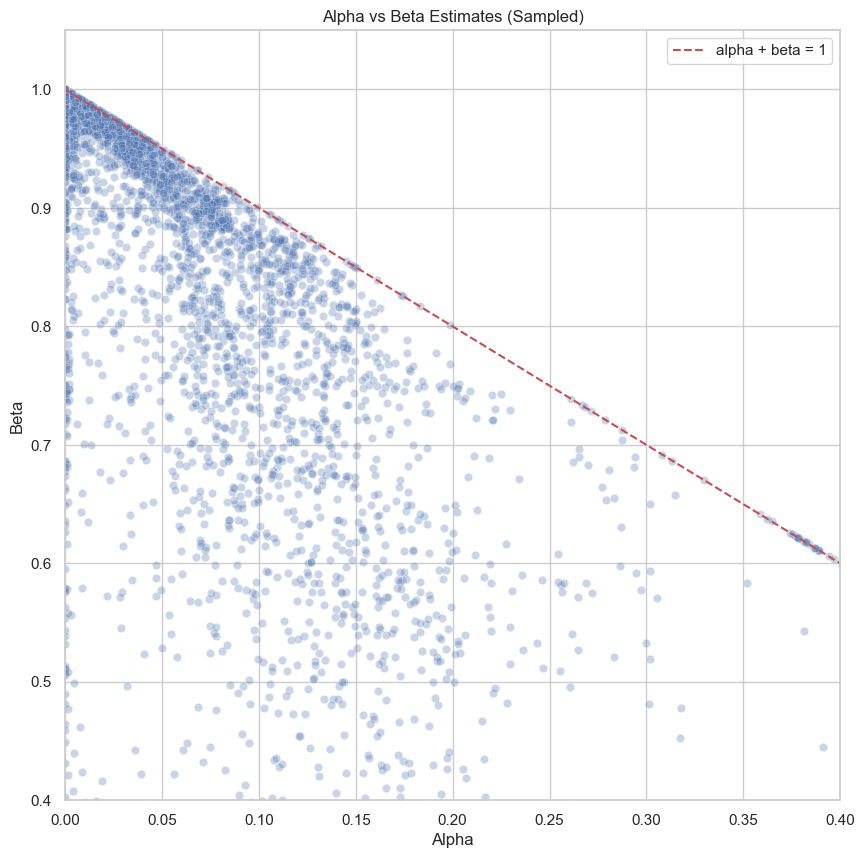

In [16]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df.sample(min(5000, len(df))), x='alpha', y='beta', alpha=0.3)
plt.plot([0, 1], [1, 0], 'r--', label='alpha + beta = 1')
plt.xlim(0, 0.4)
plt.ylim(0.4, 1.05)
plt.title('Alpha vs Beta Estimates (Sampled)')
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.legend()
plt.show()

## 5. Parameter Evolution Over Time (Sample Firms)
We select 5 random firms to visualize how their GARCH parameters evolve over the rolling windows.

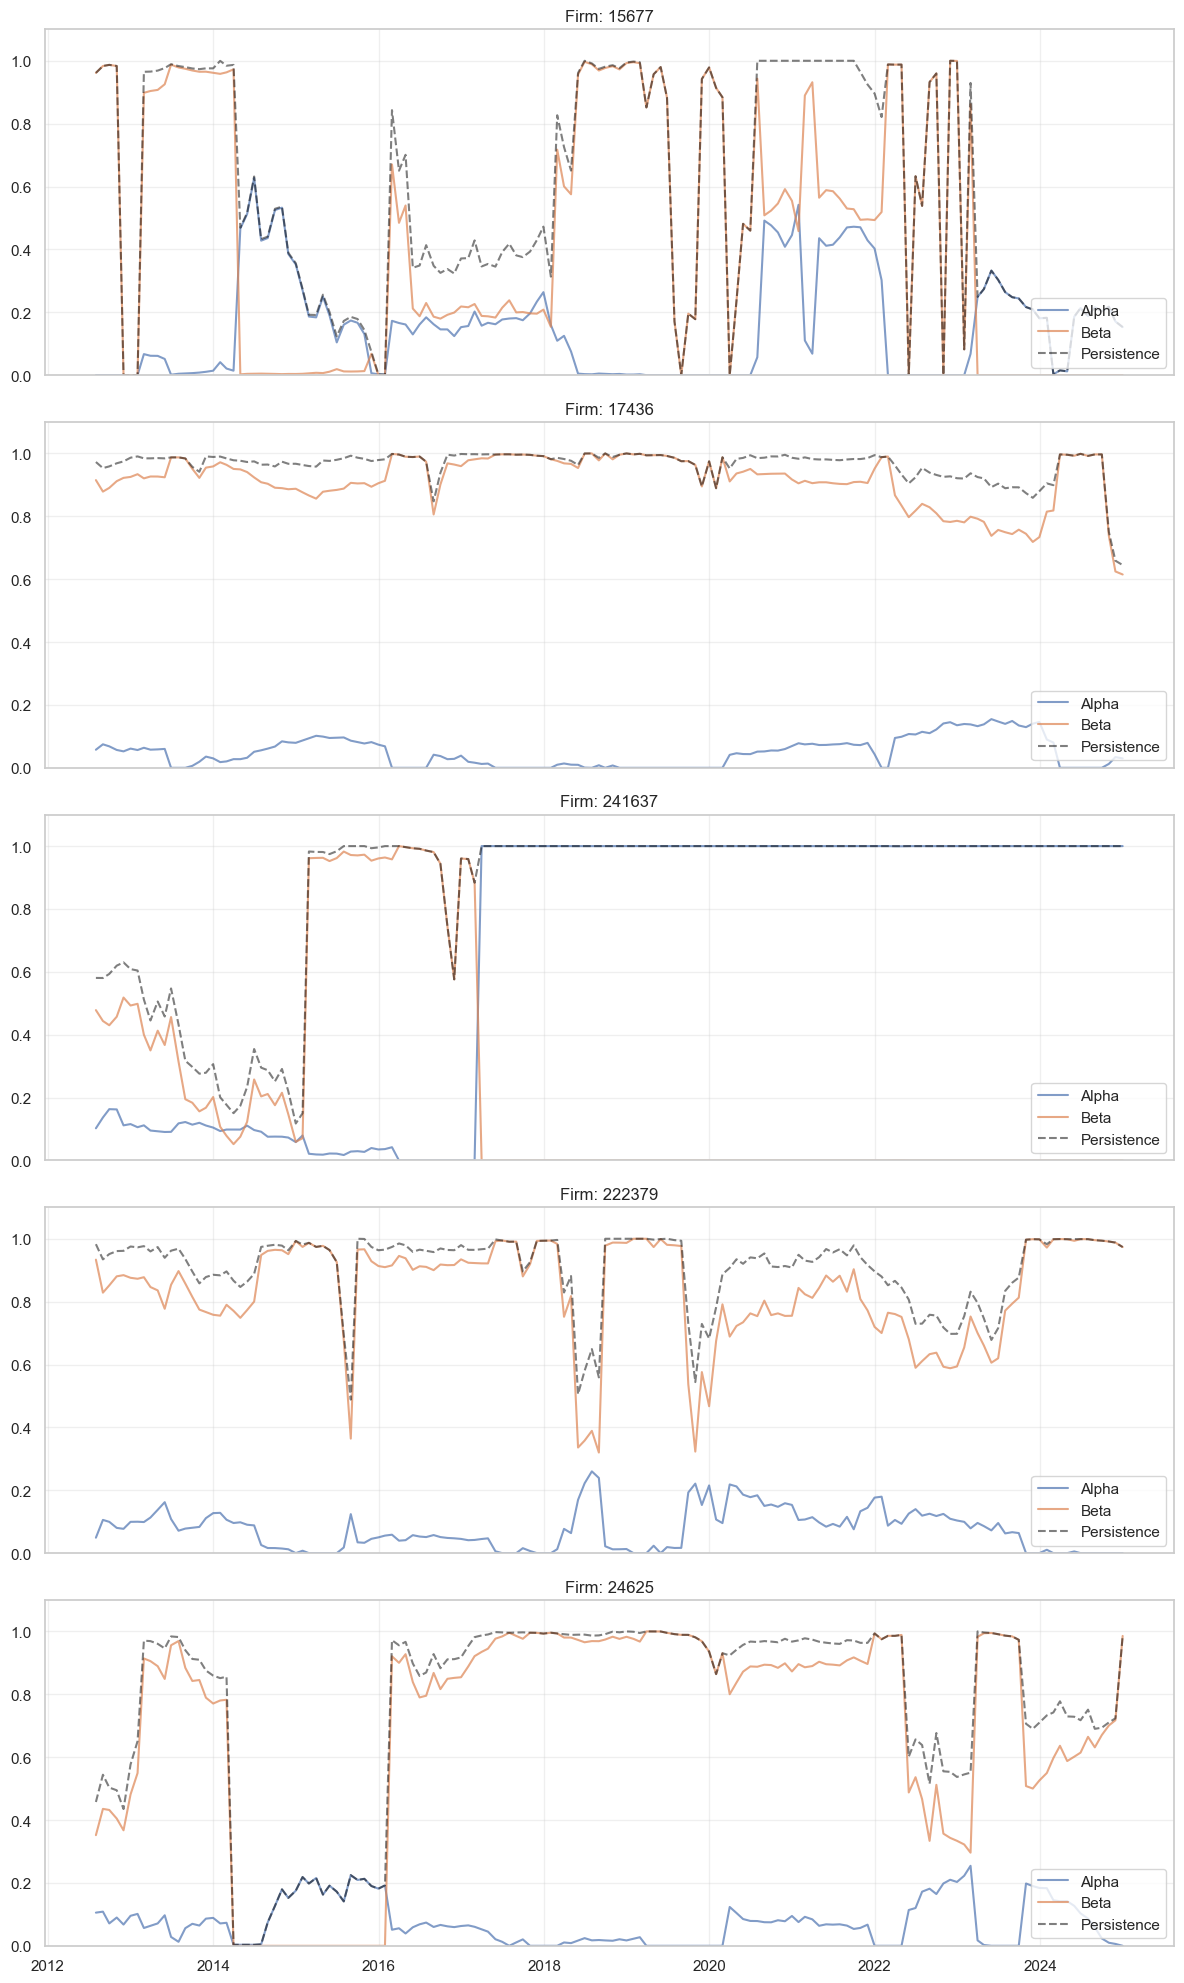

In [17]:
sample_firms = np.random.choice(df['gvkey'].unique(), 5, replace=False)

fig, axes = plt.subplots(len(sample_firms), 1, figsize=(12, 4*len(sample_firms)), sharex=True)

if len(sample_firms) == 1: axes = [axes]

for ax, gvkey in zip(axes, sample_firms):
    firm_data = df[df['gvkey'] == gvkey].sort_values('date')
    
    ax.plot(firm_data['date'], firm_data['alpha'], label='Alpha', alpha=0.7)
    ax.plot(firm_data['date'], firm_data['beta'], label='Beta', alpha=0.7)
    ax.plot(firm_data['date'], firm_data['persistence'], label='Persistence', linestyle='--', color='black', alpha=0.5)
    
    ax.set_title(f"Firm: {gvkey}")
    ax.set_ylim(0, 1.1)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Identifying Problematic Estimations
- **High Persistence**: $\alpha + \beta \ge 0.999$
- **Explosive**: $\alpha + \beta > 1.0$
- **Unusually Low Beta**: $\beta < 0.5$ (might indicate model misspecification for daily data)
- **High Alpha**: $\alpha > 0.3$ (very erratic volatility)

In [18]:
print("Diagnostic Summary:")
print(f"Total Estimations: {len(df)}")
print(f"Persistence >= 0.99: {len(df[df['persistence'] >= 0.99])}")
print(f"Persistence > 1.00: {len(df[df['persistence'] > 1.00])}")
print(f"Beta < 0.1: {len(df[df['beta'] < 0.1])}")
print(f"Nu < 2.1 (Undefined Variance): {len(df[df['nu'] < 2.1])}")

Diagnostic Summary:
Total Estimations: 5100
Persistence >= 0.99: 1498
Persistence > 1.00: 297
Beta < 0.1: 709
Nu < 2.1 (Undefined Variance): 190
